In [3]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import tensorflow as tf
print('Tensorflow version', tf.__version__)

%matplotlib inline
matplotlib.style.use("ggplot")

Tensorflow version 1.1.0


<ol>
<li><a href="#Loading-and-Formatting-Data">Loading and Formatting Data</a></li>
<li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
<li><a href="#Test-Model">Test Model</a></li>
</ol>

# Loading and Formatting Data

In [4]:
synth_data = loadmat('./fabricated_mnist_data/data_and_labels.mat')
all_x = synth_data['data']
all_y = synth_data['labels']
print("X shape", all_x.shape)
print("Y 'shape'", all_y.shape)
print("Y first example shape", all_y[0, 0].shape)
print("Y last example shape", all_y[0, -1].shape)

X shape (23330, 28, 140)
Y 'shape' (1, 23330)
Y first example shape (1, 10)
Y last example shape (5, 10)


Reshape y by padding < 5 length labels, and getting the length of the labels

In [5]:
all_y = all_y.reshape(-1)
all_y_lens = np.array([len(y_ex) for y_ex in all_y])
def pad(y_ex):  # padding with "no char" encodings
    toreturn = np.zeros((5, 11))
    toreturn[:len(y_ex), :-1] = y_ex
    toreturn[len(y_ex):, -1] = 1
    return toreturn
pad(np.arange(10*2).reshape(2, 10))


array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,   0.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]])

In [6]:
all_y = np.array([pad(y_ex) for y_ex in all_y])
all_y.shape

(23330, 5, 11)

Define train-test-validation split and reshape the data to explicitly have channel size 1

In [7]:
all_x.shape

(23330, 28, 140)

In [8]:
np.random.seed(999)
idx = np.arange(len(all_x))
np.random.shuffle(idx)
temp = len(all_x)//5

train_idx = idx[:(temp*3)]
valid_idx = idx[(temp*3):(temp*4)]
test_idx = idx[(temp*4):]

train_x = all_x[train_idx].reshape(-1, 28, 140, 1)
train_y = all_y[train_idx]

valid_x = all_x[valid_idx].reshape(-1, 28, 140, 1)
valid_y = all_y[valid_idx]

test_x = all_x[test_idx].reshape(-1, 28, 140, 1)
test_y = all_y[test_idx]

In [9]:
all_y.shape

(23330, 5, 11)

# Defining Helper Functions

In [10]:
def masked_xe(output, target):
    """Compute the average cross entropy of sequences up to the lengths of the targets.
    
    This assumes a target is of shape [N, L, K], where N is the number of examples, L is the maximum 
    sequence length, and K is the number of classes. Additionally, target should be zero-padded to
    arrive at the max sequence length for all sequences
    
    Borrowed from https://danijar.com/variable-sequence-lengths-in-tensorflow/.
    """
    
    cross_entropy = target * tf.log(output)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)
    mask = tf.sign(tf.reduce_max(tf.abs(target), reduction_indices=2))
    cross_entropy *= mask
    
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    cross_entropy /= tf.reduce_sum(mask, reduction_indices=1)
    return tf.reduce_mean(cross_entropy)

In [11]:
def get_pred(y):
    digits = np.argmax(y, axis=-1)
    
    return [''.join([str(x).replace('10', '_') for x in dig]) for dig in digits]
digs = [
    [
        [0, 1]+[0]*9,
        [0, 0.2, 0.8] + [0]*8,
        [0, 1]+[0]*9,
        [0, 0.2, 0.8] + [0]*8,
        [0]*10 + [1]
    ]
]
get_pred(digs)

['1212_']

In [12]:
def c(a):
    if isinstance(a, tf.Tensor):
        return a.eval()
    else:
        return a

In [13]:
def accuracy(y_true, y_pred):
    y_true = c(y_true)
    y_pred = c(y_pred)
    actual = np.array(get_pred(y_true))
    pred = np.array(get_pred(y_pred))
    return np.mean(actual == pred)

# Test Model

In [29]:
lr = 0.001
simplest_graph =  tf.Graph()

In [56]:
with simplest_graph.as_default(): 
    tf_x = tf.placeholder(tf.float32, (None, all_x.shape[1], all_x.shape[2], 1))
    tf_y = tf.placeholder(tf.float32, (None, all_y.shape[1], all_y.shape[2]))
    
    # (N, 28, 140, 1)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 5], stddev=0.1, seed=54), name="conv1_w")
    conv1_b = tf.Variable(tf.zeros(shape=[5]), name="conv1_b")
    
    # (N, 28, 140, 5)
    conv2_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 5, 5], stddev=0.1, seed=741), name="conv2_w")
    conv2_b = tf.Variable(tf.zeros(shape=[5]), name="conv2_b")
    
    # (N, 28, 140, 5)
    
    
    # (N, 15, 71, 5)
    conv4_w = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 15], stddev=0.1, seed=11), name="conv4_w")
    conv4_b = tf.Variable(tf.zeros(shape=[15]), name="conv4_b")
    
    # (N, 15, 71, 15)
    conv5_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 15, 7], stddev=0.1, seed=11), name="conv5_w")
    conv5_b = tf.Variable(tf.zeros(shape=[7]), name="conv5_b")
    
    # (N, 15, 71, 7)
        
    # (N, 8, 36, 7)
    conv7_w = tf.Variable(tf.truncated_normal(shape=[2, 4, 7, 4], stddev=0.1, seed=11), name="conv7_w")
    conv7_b = tf.Variable(tf.zeros(shape=[4]), name="conv7_b")
    
    
    # (N, 8, 36, 4) -> (N, 1410)
    dens8_w = tf.Variable(tf.truncated_normal(shape=[980, 400], stddev=0.1, seed=65), name="dens8_w")
    dens8_b = tf.Variable(tf.zeros(shape=[400]), name="dens8_b")
    
    # (N, 200)
    dig_w = tf.Variable(tf.truncated_normal(shape=[400, 5*11], stddev=0.1, seed=87), name="dig_w")
    dig_b = tf.Variable(tf.zeros(shape=[5*11]), name="dig_b")

In [57]:
def model(x):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    odig = tf.nn.relu(tf.matmul(o8, dig_w) + dig_b)
    return odig

In [58]:
with simplest_graph.as_default():
    
    tf_diglogit = model(tf_x)
    tf_diglogit = tf.reshape(tf_diglogit, shape=[-1, 5, 11])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    print(tf_diglogit.get_shape())
    tf_dig_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_y, logits=tf_diglogit))
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_dig_loss)

(?, 5, 11)


In [59]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 2500
compare_every = 30
t_losses, v_losses = [], []
t_acc, v_acc = [], []

In [60]:
def capture_performance():
    global session
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global valid_x
    global valid_y
    global t_acc
    global v_acc
#     print('Saving performance')
    
    train_loss, train_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                                   feed_dict={
        tf_x: train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_y: train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
    })
    
    valid_loss, valid_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                                   feed_dict={
        tf_x: valid_x, tf_y: valid_y})
    
    t_losses.append(np.mean(train_loss))
    t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                          train_proba,))
    v_losses.append(np.mean(valid_loss))
    v_acc.append(accuracy(valid_y, valid_proba))                      

In [61]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        _, batch_dig_loss = session.run([updater, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y})
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_loss, v_proba = session.run([tf_dig_loss, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, v_dig_proba)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='best')
    plt.show()

C:\Users\Ian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


KeyboardInterrupt: 

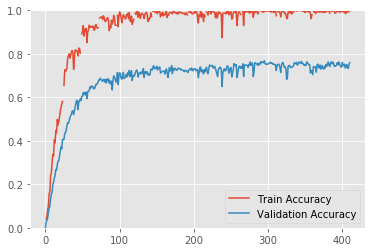

In [213]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()

# Keras model version

In [14]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.4'

In [15]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, Masking, Activation
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.activations import softmax
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [20]:
in0 = Input(shape=[all_x.shape[1], all_x.shape[2], 1], name='X')
conv1 = Conv2D(5, (3, 3), strides=(1, 1), padding='same', activation='relu')(in0)
conv2 = Conv2D(5, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv1)
max3 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv2)
conv4 = Conv2D(15, (3, 3), strides=(1, 1), padding='same', activation='relu')(max3)
conv5 = Conv2D(7, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv4)
max6 = MaxPooling2D((2, 2), (2, 2), padding='same')(conv5)
conv7 = Conv2D(4, (2, 4), strides=(1, 1), padding='same', activation='relu')(max6)
resh7 = Reshape([980])(conv7)
dens8 = Dense(400, activation='relu', kernel_regularizer=l2(0.003))(resh7)
dens8 = Dropout(0.75)(dens8)

dig_9 = Dense(5*11, activation='linear', kernel_regularizer=l2(0.001))(dens8)
resh9 = Reshape([5, 11])(dig_9)
softmax9 = Activation('softmax')(resh9)

model = Model(in0, outputs=[softmax9])
opt = Adam(0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [21]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [22]:
def capture_performance2():
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global valid_x
    global valid_y
    global t_acc
    global v_acc
#     print('Saving performance')
    try:
        train_dig_proba = model.predict(train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)])
        t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                      train_dig_proba))
    except:
        t_acc.append(np.nan)
    
    valid_dig_proba = model.predict(valid_x)
    v_acc.append(accuracy(valid_y, valid_dig_proba))                      

4608/4666 [============================>.] - ETA: 0sEpoch 0
Validation accuracy 31.976%
Mean batch dig loss 1.420
Valid dig loss 1.112


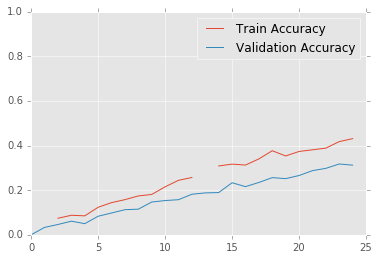

KeyboardInterrupt: 

In [25]:
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        total_loss = model.train_on_batch(batch_x, batch_y)
        
        ep_dig_losses.append(total_loss)
        if (batch_idx) % compare_every == 0:
            capture_performance2()
                   
    v_dig_proba = model.predict(valid_x)
    v_dig_loss = model.evaluate(valid_x, valid_y)
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, v_dig_proba)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()